In [1]:
## Importing the necessary packages


import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')
% cd 'drive/My Drive/ECE C147'
% cd 'project'
% ls


Mounted at /content/drive
/content/drive/My Drive/ECE C147
/content/drive/My Drive/ECE C147/project
EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy              y_test.npy


## Loading the dataset and creating a windowed version

In [3]:
## Loading the numpy arrays

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))




Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
def make_steps(samples,samples_per_frame,stride):
    '''
    in:
    samples - number of samples in the session
    samples_per_frame - number of samples in the frame
    stride - the gap between succesive frames
    out: list of tuple ranges
    '''
    
    i = 0
    intervals = []
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + stride
    return intervals

def make_win_data_pipeline(data_arr,label_arr,num_samples_frame,stride):
    '''
    in:
    data_arr - original data array without windowing
    label_arr - labels of the data array without windowing
    num_samples_frame - number of samples in the frame
    stride - the gap between succesive frames
    
    out:
    data_win_arr - windowed data array
    label_win_arr - labels of the windowed data array
    
    '''
    
    num_trials = data_arr.shape[0]
    num_channels = data_arr.shape[1]
    num_samples = data_arr.shape[2]
    
    steps_list = make_steps(num_samples,num_samples_frame,stride)
    num_windows = len(steps_list)
    
    data_win_arr = np.zeros((num_trials*num_windows,num_channels,num_samples_frame))
    label_win_arr = []
    k = 0
    
    for i in range(num_trials):
        
        trial_label = label_arr[i]
        trial_data = data_arr[i,:,:]
        
        for m,n in enumerate(steps_list):
            start_ind = n[0]
            end_ind = n[1]
            
            win_data = trial_data[:,start_ind:end_ind]
            data_win_arr[k,:,:] = win_data
            label_win_arr.append(trial_label)
            k = k+1
    
    label_win_arr = np.asarray(label_win_arr)
    return data_win_arr, label_win_arr


## Creating the custom dataset for torch

In [5]:
# Creating the custom dataset

class EEGDataset(Dataset):
    
    """EEG dataset"""
    def __init__(self, subset, transform=None):
        
        'Initialization'
        
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        
        'Generates one sample of data'
        
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        
        'Denotes the total number of samples'
        return len(self.subset)
    


## Defining the models

In [6]:
# Defining the shallow conv net


class ShallowConv(nn.Module):
    
    # Defining the building blocks of shallow conv net
    
    def __init__(self, in_channels, num_conv_filters, num_samples_frame, num_eeg_channels,classes):
    
        # Defining as a subclass
        super(ShallowConv, self).__init__()

        self.num_samples_frame = num_samples_frame
        self.num_conv_filters = num_conv_filters
        self.num_eeg_channels = num_eeg_channels
        
        # Define the convolution layer, https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(in_channels, self.num_conv_filters, (1, 25), stride=1)
        self.conv_output_width =  int(self.num_samples_frame - (25-1) - 1 + 1)
        
        # Define the 2d batchnorm layer
        self.bnorm2d = nn.BatchNorm2d(self.num_conv_filters)
        
        # Define the 1d batchnorm layer
        self.bnorm1d = nn.BatchNorm1d(self.num_conv_filters)


        # Define the fc layer, https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc1 = nn.Linear(self.num_eeg_channels*self.num_conv_filters, self.num_conv_filters)
        
        # Define the elu activation
        self.elu = nn.ELU(0.2)

        # Define the avg pooling layer
        self.avgpool = nn.AvgPool1d(75, stride=15)
        
        self.num_features_linear = int(np.floor(((self.conv_output_width - 75)/15)+1))
        
        

        # Define the fc layer for generating the scores for classes 
        self.fc2 = nn.Linear(self.num_features_linear*self.num_conv_filters, classes)

    
    
      # Defining the connections of shallow conv net
    
    def forward(self, x):
        
        # Reshaping the input for 2-D convolution (B,22,num_samples_frame) -> (B,1,22,num_samples_frame)
        
        x = x.view(-1, 1, 22, self.num_samples_frame)
        
        # Performing the 2-D convolution (B,1,22,300) -> (B,40,22,x_shape_4dim)
        
        x = self.conv1(x)
        x_shape_4dim = x.shape[3]
        
        # ELU activation
        
        x = self.elu(x)
        
        # 2d Batch normalization
        
        x = self.bnorm2d(x)
        
        
        # Reshaping the input to dense layer (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,880)
        
        x = x.permute(0,3,1,2) # (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,40,22)
        x = x.view(-1,x_shape_4dim,880)
        
        # Passing through the dense layer (B,x_shape_4dim,880) -> (B,x_shape_4dim,40)
        
        x = self.fc1(x)
        
        # ELU activation
        
        x = self.elu(x)
        
        # Square activation
        
        x = torch.square(x)
        
        # Reshaping the input for average pooling layer (B,x_shape_4dim,40) -> (B,40,x_shape_4dim)
        
        x = x.permute(0,2,1)
        
        # Passing through the average pooling layer (B,40,x_shape_4dim) -> (B,40,x_pool_3dim)
        
        x = self.avgpool(x)
        x_pool_3dim = x.shape[2]
        
        # Log activation
        
        x = torch.log(x)
        
        # 1D Batch normalization
        
        x = self.bnorm1d(x)
        #print(x.shape)
        
        # Reshaping the input to dense layer (B,40,x_pool_3dim) -> (B,40*x_pool_3dim)
        
        x = x.reshape(-1, 40*x_pool_3dim)
        
        # Passing through the dense layer (B,40*x_pool_3dim) -> (B,classes)
        
        x = self.fc2(x)
        
        # Passing through the softmax layer
        
        
        
        return x

## Defining the training and validation of the model

In [7]:
## Defining the training and validation function

def train_val(model,optimizer,criterion,num_epochs):
    
    
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        
        
        
        for phase in ['train','val']:
            
            
            
            #Initializing the losses and accuracy
            
            training_loss = 0
            correct_train_preds = 0
            total_train_preds = 0
            batch_train_idx = 0
            
            validation_loss = 0
            correct_val_preds = 0
            total_val_preds = 0
            batch_val_idx = 0
            
            
            # Implementing the training phase
            
            if phase == 'train':
                
                # setting the model to training mode
                
                model.train()
                
                # Loading the training dataset in batches 
                
                for inputs, labels in dataloaders['train']:
                    
                    # Transfer input data and labels to device
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Incrementing the batch counter
                    
                    batch_train_idx += 1
                    
                    # Zeroing the gradient buffer
                    
                    optimizer.zero_grad()
                    
                    # Perform the forward pass
                    
                    outputs = model(inputs)
                    
                    # Compute loss
                    
                    loss = criterion(outputs,labels)
                    
                    
                    # Perform the backward pass
                    
                    loss.backward()
                    
                    # Perform optimization step
                    
                    optimizer.step()
                    
                    # Compute training statistics
                    
                    training_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total_train_preds += labels.size(0)
                    correct_train_preds += predicted.eq(labels).sum().item()
                    
                
                train_loss.append(training_loss)
                t_acc = correct_train_preds/total_train_preds
                train_acc.append(t_acc)
                print('Training loss:',training_loss)
                print('Training accuracy:',t_acc)
                
                    
            else:
                
                
                
                # setting the model to evaluation mode
                
                model.eval()
                
                # Disable gradient computation
                
                with torch.no_grad():
                    
                    # Loading the training dataset in batches 
                    
                    for val_inputs, val_labels in dataloaders['val']:
                        
                        
                        # Transfer input data and labels to device
                    
                        val_inputs = val_inputs.to(device)
                        val_labels = val_labels.to(device)
                        
                        # Incrementing the batch counter
                    
                        batch_val_idx += 1
                        
                        # Perform forward pass
                        
                        val_outputs = model(val_inputs)
                        
                        # Compute loss
                        
                        valid_loss = criterion(val_outputs,val_labels)
                        
                        
                        # Compute validation statistics
                    
                        validation_loss += valid_loss.item()
                        _, val_predicted = val_outputs.max(1)
                        total_val_preds += val_labels.size(0)
                        correct_val_preds += val_predicted.eq(val_labels).sum().item()
                        
                    val_loss.append(validation_loss)
                    v_acc = correct_val_preds/total_val_preds
                    val_acc.append(v_acc)
                    print('Validation loss:',validation_loss)
                    print('Validation accuracy:',v_acc)
            

            
           
        
    return model, train_loss, train_acc, val_loss, val_acc
                    

## Training,validating and testing the model with 1000 samples per trial

In [8]:
## Preparing the training and validation data

num_samples_frame = 1000
stride = 50
X_train_win,y_train_win = make_win_data_pipeline(X_train_valid,y_train_valid,num_samples_frame,stride)

print ('Windowed Training/Valid data shape: {}'.format(X_train_win.shape))
print ('Windowed Training/Valid label shape: {}'.format(y_train_win.shape))

# Converting the numpy data to torch tensors

X_train_valid_tensor = torch.from_numpy(X_train_win).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_win).float().long().to(device) 

print ('Training/Valid tensor shape: {}'.format(X_train_valid_tensor.shape))
print ('Training/Valid target tensor shape: {}'.format(y_train_valid_tensor.shape))

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 

# Spliting the dataset into training and validation

lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = EEGDataset(subset_train, transform=None)
val_data = EEGDataset(subset_val, transform=None)

# Constructing the training and validation dataloaders

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
}





Windowed Training/Valid data shape: (2115, 22, 1000)
Windowed Training/Valid label shape: (2115,)
Training/Valid tensor shape: torch.Size([2115, 22, 1000])
Training/Valid target tensor shape: torch.Size([2115])


In [9]:
# Defining the parameters for model training


weight_decay = 0.15  # weight decay to alleviate overfiting
shallow_model = ShallowConv(in_channels=1, num_conv_filters=40,num_samples_frame=1000,num_eeg_channels=22,classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shallow_model.parameters(), lr = 1e-4, weight_decay=weight_decay)

# Training and validating the model
num_epoch=200
shallow_model,t_l,t_a,v_l,v_a=train_val(shallow_model, optimizer, criterion, num_epochs=num_epoch)


Epoch 0/199
----------
Training loss: 72.69222795963287
Training accuracy: 0.3398345153664303
Validation loss: 71.37843060493469
Validation accuracy: 0.34515366430260047
Epoch 1/199
----------
Training loss: 64.2348268032074
Training accuracy: 0.458628841607565
Validation loss: 68.03074586391449
Validation accuracy: 0.3829787234042553
Epoch 2/199
----------
Training loss: 58.912817895412445
Training accuracy: 0.5437352245862884
Validation loss: 66.1180517077446
Validation accuracy: 0.44208037825059104
Epoch 3/199
----------
Training loss: 54.28694397211075
Training accuracy: 0.5986997635933806
Validation loss: 63.72051686048508
Validation accuracy: 0.47754137115839246
Epoch 4/199
----------
Training loss: 49.75051301717758
Training accuracy: 0.6418439716312057
Validation loss: 61.95068734884262
Validation accuracy: 0.48936170212765956
Epoch 5/199
----------
Training loss: 45.919988095760345
Training accuracy: 0.7021276595744681
Validation loss: 60.607842206954956
Validation accuracy: 0

[0.34515366430260047, 0.3829787234042553, 0.44208037825059104, 0.47754137115839246, 0.48936170212765956, 0.4988179669030733, 0.5295508274231678, 0.5295508274231678, 0.5200945626477541, 0.5531914893617021, 0.5460992907801419, 0.5602836879432624, 0.5602836879432624, 0.5673758865248227, 0.5626477541371159, 0.5791962174940898, 0.5815602836879432, 0.5626477541371159, 0.5673758865248227, 0.5910165484633569, 0.5886524822695035, 0.5721040189125296, 0.5886524822695035, 0.5957446808510638, 0.5910165484633569, 0.574468085106383, 0.6193853427895981, 0.6004728132387707, 0.624113475177305, 0.6099290780141844, 0.5957446808510638, 0.5910165484633569, 0.6028368794326241, 0.5981087470449172, 0.5981087470449172, 0.6004728132387707, 0.5957446808510638, 0.6099290780141844, 0.6052009456264775, 0.6028368794326241, 0.5886524822695035, 0.6146572104018913, 0.6359338061465721, 0.607565011820331, 0.6264775413711584, 0.6099290780141844, 0.5460992907801419, 0.6122931442080378, 0.6052009456264775, 0.5791962174940898

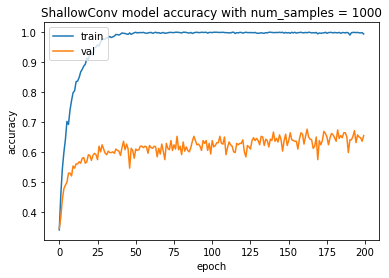

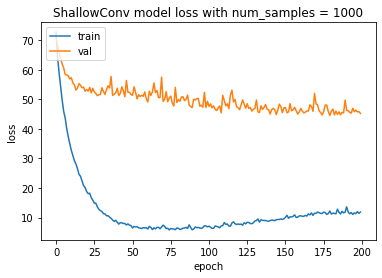

In [12]:
# Plotting the training and validation history



import matplotlib.pyplot as plt

print(v_a)
plt.plot(range(num_epoch),t_a)
plt.plot(range(num_epoch),v_a)
plt.title('ShallowConv model accuracy with num_samples = 1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



plt.plot(range(num_epoch),t_l)
plt.plot(range(num_epoch),v_l)
plt.title('ShallowConv model loss with num_samples = 1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



In [13]:
# Testing the model

num_samples_frame = 1000
stride = 50
X_test_win,y_test_win = make_win_data_pipeline(X_test,y_test,num_samples_frame,stride)

# Preparing the test dataset
X_test_tensor = torch.from_numpy(X_test_win).float().to(device)
y_test_tensor = torch.from_numpy(y_test_win).float().long().to(device) 
    
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) 
    
test_data = EEGDataset(test_dataset, transform=None)



def test_model(model,test_data,criterion):
    
    
    # Creating the test dataloader
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)
    
    # Making the predictions on the dataset
    
    total_test_preds = 0
    correct_test_preds = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        
        for test_inputs, test_labels in test_dataloader:
            
            # Transfer test data and labels to device
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            
            # Perform forward pass
            test_outputs = model(test_inputs)
            
            # Compute loss
            test_loss = criterion(test_outputs,test_labels)
            
            # Compute test statistics
                    
            test_loss += test_loss.item()
            _, test_predicted = test_outputs.max(1)
            total_test_preds += test_labels.size(0)
            correct_test_preds += test_predicted.eq(test_labels).sum().item()
            
        test_acc = correct_test_preds/total_test_preds
        print('Test loss', test_loss)
        print('Test accuracy',test_acc*100)
        
    
    return test_acc

test_a = test_model(shallow_model,test_data,criterion)

Test loss tensor(1.1953, device='cuda:0')
Test accuracy 65.23702031602708


## Training,validating and testing the model with 500 samples per trial

In [14]:
## Preparing the training and validation data

num_samples_frame = 500
stride = 100
X_train_win,y_train_win = make_win_data_pipeline(X_train_valid,y_train_valid,num_samples_frame,stride)

print ('Windowed Training/Valid data shape: {}'.format(X_train_win.shape))
print ('Windowed Training/Valid label shape: {}'.format(y_train_win.shape))

# Converting the numpy data to torch tensors

X_train_valid_tensor = torch.from_numpy(X_train_win).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_win).float().long().to(device) 

print ('Training/Valid tensor shape: {}'.format(X_train_valid_tensor.shape))
print ('Training/Valid target tensor shape: {}'.format(y_train_valid_tensor.shape))

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 

# Spliting the dataset into training and validation

lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = EEGDataset(subset_train, transform=None)
val_data = EEGDataset(subset_val, transform=None)

# Constructing the training and validation dataloaders

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
}



Windowed Training/Valid data shape: (12690, 22, 500)
Windowed Training/Valid label shape: (12690,)
Training/Valid tensor shape: torch.Size([12690, 22, 500])
Training/Valid target tensor shape: torch.Size([12690])


In [28]:
# Defining the parameters for model training


weight_decay = 0.15  # weight decay to alleviate overfiting
shallow_model = ShallowConv(in_channels=1, num_conv_filters=40,num_samples_frame=500,num_eeg_channels=22,classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shallow_model.parameters(), lr = 1e-5, weight_decay=weight_decay)

# Training and validating the model
epoch=600
shallow_model,t_l,t_a,v_l,v_a=train_val(shallow_model, optimizer, criterion, num_epochs=epoch)

Epoch 0/599
----------
Training loss: 460.23816537857056
Training accuracy: 0.25541765169424746
Validation loss: 447.3215956687927
Validation accuracy: 0.2777777777777778
Epoch 1/599
----------
Training loss: 442.6060811281204
Training accuracy: 0.2903861308116627
Validation loss: 439.56864976882935
Validation accuracy: 0.2970843183609141
Epoch 2/599
----------
Training loss: 436.1013534069061
Training accuracy: 0.3108747044917258
Validation loss: 435.7006849050522
Validation accuracy: 0.3073286052009456
Epoch 3/599
----------
Training loss: 430.8013323545456
Training accuracy: 0.32436958234830576
Validation loss: 432.5277290344238
Validation accuracy: 0.3195429472025217
Epoch 4/599
----------
Training loss: 426.7705924510956
Training accuracy: 0.34505516154452326
Validation loss: 427.9044598340988
Validation accuracy: 0.32978723404255317
Epoch 5/599
----------
Training loss: 422.0230587720871
Training accuracy: 0.35726950354609927
Validation loss: 425.3234312534332
Validation accuracy

[0.2777777777777778, 0.2970843183609141, 0.3073286052009456, 0.3195429472025217, 0.32978723404255317, 0.34948778565799843, 0.3605200945626478, 0.3731284475965327, 0.3908589440504334, 0.3979511426319937, 0.40583136327817176, 0.4176516942474389, 0.42710795902285265, 0.43656422379826637, 0.44759653270291566, 0.44720252167060676, 0.45547675334909377, 0.4657210401891253, 0.4672970843183609, 0.4661150512214342, 0.47675334909377465, 0.4799054373522459, 0.48187549251379036, 0.4842395587076438, 0.48266351457840817, 0.49724192277383766, 0.49684791174152876, 0.5015760441292356, 0.5031520882584712, 0.49724192277383766, 0.5043341213553979, 0.5070921985815603, 0.5090622537431048, 0.5169424743892829, 0.5197005516154453, 0.5149724192277384, 0.5240346729708432, 0.5224586288416075, 0.5240346729708432, 0.5437352245862884, 0.5370370370370371, 0.5350669818754925, 0.5386130811662726, 0.5472813238770685, 0.5445232466509062, 0.55397951142632, 0.5480693459416863, 0.5614657210401891, 0.5575256107171, 0.55634357

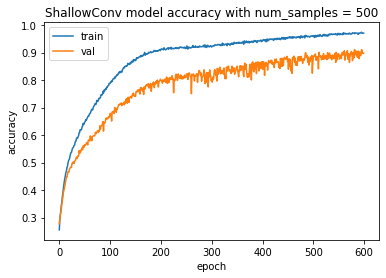

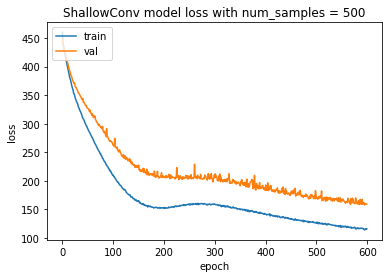

In [29]:
# Plotting the training and validation history



import matplotlib.pyplot as plt

print(v_a)
plt.plot(range(epoch),t_a)
plt.plot(range(epoch),v_a)
plt.title('ShallowConv model accuracy with num_samples = 500')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



plt.plot(range(epoch),t_l)
plt.plot(range(epoch),v_l)
plt.title('ShallowConv model loss with num_samples = 500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



In [30]:
# Testing the model

num_samples_frame = 500
stride = 100
X_test_win,y_test_win = make_win_data_pipeline(X_test,y_test,num_samples_frame,stride)

# Preparing the test dataset
X_test_tensor = torch.from_numpy(X_test_win).float().to(device)
y_test_tensor = torch.from_numpy(y_test_win).float().long().to(device) 
    
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) 
    
test_data = EEGDataset(test_dataset, transform=None)

test_a = test_model(shallow_model,test_data,criterion)

Test loss tensor(1.7838, device='cuda:0')
Test accuracy 48.23175319789315


## Training,validating and testing the model with 300 samples per trial

In [31]:
## Preparing the training and validation data

num_samples_frame = 300
stride = 60
X_train_win,y_train_win = make_win_data_pipeline(X_train_valid,y_train_valid,num_samples_frame,stride)

print ('Windowed Training/Valid data shape: {}'.format(X_train_win.shape))
print ('Windowed Training/Valid label shape: {}'.format(y_train_win.shape))

# Converting the numpy data to torch tensors

X_train_valid_tensor = torch.from_numpy(X_train_win).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_win).float().long().to(device) 

print ('Training/Valid tensor shape: {}'.format(X_train_valid_tensor.shape))
print ('Training/Valid target tensor shape: {}'.format(y_train_valid_tensor.shape))

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 

# Spliting the dataset into training and validation

lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
subset_train, subset_val = random_split(init_dataset, lengths) 

train_data = EEGDataset(subset_train, transform=None)
val_data = EEGDataset(subset_val, transform=None)

# Constructing the training and validation dataloaders

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=False, num_workers=0)
}



Windowed Training/Valid data shape: (25380, 22, 300)
Windowed Training/Valid label shape: (25380,)
Training/Valid tensor shape: torch.Size([25380, 22, 300])
Training/Valid target tensor shape: torch.Size([25380])


In [33]:
# Defining the parameters for model training


weight_decay = 0.15  # weight decay to alleviate overfiting
shallow_model = ShallowConv(in_channels=1, num_conv_filters=40,num_samples_frame=300,num_eeg_channels=22,classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shallow_model.parameters(), lr = 1e-5, weight_decay=weight_decay)
epoch=500
# Training and validating the model

shallow_model,t_l,t_a,v_l,v_a=train_val(shallow_model, optimizer, criterion, num_epochs=epoch)

Epoch 0/499
----------
Training loss: 899.4559819698334
Training accuracy: 0.2649724192277384
Validation loss: 886.546524643898
Validation accuracy: 0.27698975571316
Epoch 1/499
----------
Training loss: 879.5671920776367
Training accuracy: 0.28669227738376674
Validation loss: 876.7317409515381
Validation accuracy: 0.2929472025216706
Epoch 2/499
----------
Training loss: 869.9990636110306
Training accuracy: 0.30629432624113473
Validation loss: 870.6666556596756
Validation accuracy: 0.30437352245862886
Epoch 3/499
----------
Training loss: 862.591507434845
Training accuracy: 0.3182131599684791
Validation loss: 863.6851269006729
Validation accuracy: 0.3195429472025217
Epoch 4/499
----------
Training loss: 855.5161664485931
Training accuracy: 0.33712568951930655
Validation loss: 858.0314284563065
Validation accuracy: 0.32959022852639874
Epoch 5/499
----------
Training loss: 846.7213417291641
Training accuracy: 0.35224586288416077
Validation loss: 850.2422803640366
Validation accuracy: 0.3

[0.27698975571316, 0.2929472025216706, 0.30437352245862886, 0.3195429472025217, 0.32959022852639874, 0.347123719464145, 0.3605200945626478, 0.38081166272655637, 0.38987391646966113, 0.3983451536643026, 0.4083924349881797, 0.42257683215130026, 0.42139479905437355, 0.435973207249803, 0.44188337273443656, 0.4466115051221434, 0.4517336485421592, 0.45468873128447596, 0.4643420015760441, 0.45488573680063044, 0.4649330181245075, 0.475177304964539, 0.48187549251379036, 0.47832939322301027, 0.48699763593380613, 0.48955870764381404, 0.49527186761229314, 0.49901497241922776, 0.49645390070921985, 0.49940898345153667, 0.4992119779353822, 0.5078802206461781, 0.5110323089046493, 0.5141843971631206, 0.5173364854215918, 0.5244286840031521, 0.5262017336485422, 0.5323089046493302, 0.5372340425531915, 0.539598108747045, 0.5411741528762806, 0.5425531914893617, 0.5468873128447597, 0.5514184397163121, 0.553585500394011, 0.5522064617809299, 0.5709219858156028, 0.5606776989755713, 0.5567375886524822, 0.5596926

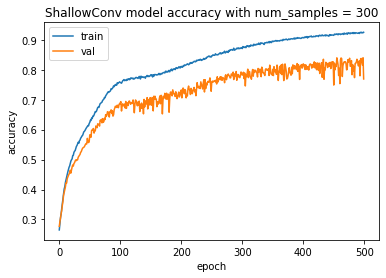

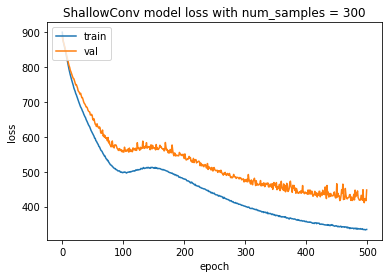

In [34]:
# Plotting the training and validation history



import matplotlib.pyplot as plt

print(v_a)
plt.plot(range(epoch),t_a)
plt.plot(range(epoch),v_a)
plt.title('ShallowConv model accuracy with num_samples = 300')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



plt.plot(range(epoch),t_l)
plt.plot(range(epoch),v_l)
plt.title('ShallowConv model loss with num_samples = 300')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()



In [35]:
# Testing the model

num_samples_frame = 300
stride = 60
X_test_win,y_test_win = make_win_data_pipeline(X_test,y_test,num_samples_frame,stride)

# Preparing the test dataset
X_test_tensor = torch.from_numpy(X_test_win).float().to(device)
y_test_tensor = torch.from_numpy(y_test_win).float().long().to(device) 
    
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) 
    
test_data = EEGDataset(test_dataset, transform=None)

test_a = test_model(shallow_model,test_data,criterion)

Test loss tensor(2.7331, device='cuda:0')
Test accuracy 40.105342362678705
